In [1]:
import keras
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
import numpy as np
import pickle
import tensorflow as tf

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility
from utils import read_input, generate_data

np.set_printoptions(suppress=True)

Using TensorFlow backend.


In [2]:
# constants
NUM_CLASSES = 20
input_shape = (300, 300, 3)
image_size = input_shape[:2]
batch_size = 32

In [3]:
# read input dataset
train, val = read_input.read_input(img_shape=input_shape[:2], num_cls=NUM_CLASSES)
t_img_path, t_label, t_bbox = train
v_img_path, v_label, v_bbox = val
# length of train and val
num_train = len(t_label)
num_val = len(v_label)

In [4]:
# load precalculate bbox {xmin, ymin, xmax, ymax}
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
# note here `+1` means background class
# becuase in BBoxUtility, it use array value to decide procedure.
bbox_util = BBoxUtility(NUM_CLASSES+1, priors)

In [5]:
model = SSD300(input_shape, num_classes=NUM_CLASSES+1)
model.load_weights('checkpoints/weights.29-5.37.hdf5', by_name=True)

In [ ]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']

# freeze pre-trained conv
for L in model.layers:
    if L.name in freeze:
        L.trainable = False

# callback
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

# loss function and optimiser
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES+1, neg_pos_ratio=2.0).compute_loss)

nb_epoch = 30
generator = generate_data.Generator(train, val, bbox_util, batch_size=batch_size, image_size=image_size)
gen = generator.generate()
genF = generator.generate(train=False)
history = model.fit_generator(generator=gen, steps_per_epoch=int(num_train/batch_size),
                              epochs=nb_epoch, verbose=1, callbacks=callbacks,
                              validation_data=genF, validation_steps=int(num_val/batch_size))


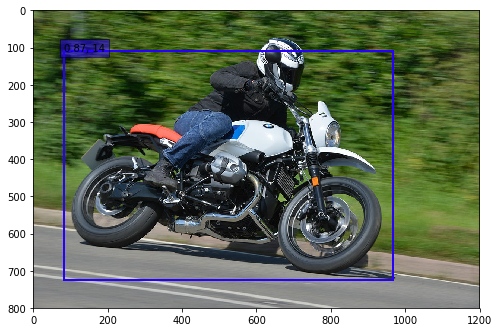

In [6]:
from utils import demo
%matplotlib inline

img_path='./pics/my-test-motor-man.jpg'
demo.demo(model, img_path, bbox_util)